# Data Analysis of LLMs generated texts

Import needed libraries

In [ ]:
import re
from collections import Counter
import powerlaw
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
from scipy.stats import linregress, ttest_ind, pearsonr
from numpy import argsort, logspace
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.utils import resample

Load texts

In [2]:
warnings.filterwarnings("ignore")

with open(r"generated_data/merged_horror_stories_lowtemp.txt", "r", encoding="utf-8") as f:
    text_horror_lowtemp = f.read().lower()
with open(r"generated_data/merged_horror_stories1.txt", "r", encoding="utf-8") as f:
    text_horror= f.read().lower()

with open(r"generated_data/merged_scientific_lowtemp.txt", "r", encoding="utf-8") as f:
    text_scientific_lowtemp = f.read().lower()
with open(r"generated_data/merged_scientific.txt", "r", encoding="utf-8") as f:
    text_scientific= f.read().lower()

with open(r"generated_data/merged_surreal_narrative_lowtemp.txt", "r", encoding="utf-8") as f:
    text_surreal_narrative_lowtemp = f.read().lower()
with open(r"generated_data/merged_surreal_narrative.txt", "r", encoding="utf-8") as f:
    text_surreal_narrative= f.read().lower()

The function 'rank_frequs' tokenizes the input text, counts word frequencies, assigns ranks, and returns a DataFrame with word, rank, frequency, and relative frequency. It prepares the data for Zipf’s law analysis.

In [4]:
def rank_frequs(text):
    words = re.findall(r"\b[a-z]+\b", text)
    word_counts = Counter(words) # count word frequency in a dictionary

    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    word_freq_df['rank'] = 1
    for i in range(1, len(word_freq_df)):
        if word_freq_df['frequency'][i] != word_freq_df['frequency'][i - 1]:
            word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
        else: 
            word_freq_df['rank'][i] = word_freq_df['rank'][i -1]

    word_freq_df = word_freq_df[['rank', 'word', 'frequency']]
    word_freq_df['rel_freq'] = word_freq_df['frequency']/sum(word_freq_df['frequency'])

    return(word_freq_df)

Apply the function rank_frequs on all texts

In [5]:
df_horror = rank_frequs(text_horror)
df_horror_lowtemp = rank_frequs(text_horror_lowtemp)

df_scientific = rank_frequs(text_scientific)
df_scientific_lowtemp = rank_frequs(text_scientific_lowtemp)

df_surreal_narrative = rank_frequs(text_surreal_narrative)
df_surreal_narrative_lowtemp = rank_frequs(text_surreal_narrative_lowtemp)

Inspect some of the dataframes

In [5]:
df_horror.head()

,rank,word,frequency,rel_freq
0,1,the,46679,0.085244
1,2,and,17910,0.032707
2,3,of,16260,0.029694
3,4,a,16087,0.029378
4,5,to,13412,0.024493


In [6]:
df_scientific.tail()

,rank,word,frequency,rel_freq
10689,392,resection,1,0.000002
10690,392,struggle,1,0.000002
10691,392,resected,1,0.000002
10692,392,rpa,1,0.000002
10693,392,corona,1,0.000002


Before fitting the Zipfian curve, we trim the long tail of the rank-frequency distribution. This section is typically noisy and includes many hapax legomena—words that occur only once—which can distort the slope and flatten the log-log plot. As a result, fitting the entire distribution often leads to:

- Underestimation of R², reducing the perceived quality of the power-law fit

- Inflated Zipf exponent (α), due to the influence of rare, topic-specific words

Empirical studies show that Zipf’s law is most valid in the head of the distribution, therefore trimming the tail ensures a more accurate and meaningful estimation of the Zipfian relationship

We fit a power-law model to each corpus using the powerlaw package, estimating the lower bound (xmin) where the Zipfian behavior begins. Frequencies below xmin are excluded to remove the noisy long tail, which can distort the fit. For each dataset, we report:

- The estimated xmin

- The total number of words (tokens)

- The number of unique words before and after trimming

In [6]:
import powerlaw

# Horror
tokens_horror = df_horror['frequency'].sum()
len_horror_before = len(df_horror)
fit_horror = powerlaw.Fit(df_horror['frequency'], discrete=True)
xmin_horror = fit_horror.power_law.xmin
df_horror = df_horror[df_horror['frequency'] >= xmin_horror]
len_horror_after = len(df_horror)
print("Horror - xmin:", xmin_horror, 
      " | Unique Words Before:", len_horror_before, 
      " | Unique Words After:", len_horror_after, 
      " | Total Words (Tokens):", tokens_horror)
print("\n")

# Horror Low Temp
tokens_horror_low = df_horror_lowtemp['frequency'].sum()
len_horror_low_before = len(df_horror_lowtemp)
fit_horror_low = powerlaw.Fit(df_horror_lowtemp['frequency'], discrete=True)
xmin_horror_low = fit_horror_low.power_law.xmin
df_horror_lowtemp = df_horror_lowtemp[df_horror_lowtemp['frequency'] >= xmin_horror_low]
len_horror_low_after = len(df_horror_lowtemp)
print("Horror Low Temp - xmin:", xmin_horror_low, 
      " | Unique Words Before:", len_horror_low_before, 
      " | Unique Words After:", len_horror_low_after, 
      " | Total Words (Tokens):", tokens_horror_low)
print("\n")

# Scientific
tokens_scientific = df_scientific['frequency'].sum()
len_scientific_before = len(df_scientific)
fit_scientific = powerlaw.Fit(df_scientific['frequency'], discrete=True)
xmin_scientific = fit_scientific.power_law.xmin
df_scientific = df_scientific[df_scientific['frequency'] >= xmin_scientific]
len_scientific_after = len(df_scientific)
print("Scientific - xmin:", xmin_scientific, 
      " | Unique Words Before:", len_scientific_before, 
      " | Unique Words After:", len_scientific_after, 
      " | Total Words (Tokens):", tokens_scientific)
print("\n")

# Scientific Low Temp
tokens_scientific_low = df_scientific_lowtemp['frequency'].sum()
len_scientific_low_before = len(df_scientific_lowtemp)
fit_scientific_low = powerlaw.Fit(df_scientific_lowtemp['frequency'], discrete=True)
xmin_scientific_low = fit_scientific_low.power_law.xmin
df_scientific_lowtemp = df_scientific_lowtemp[df_scientific_lowtemp['frequency'] >= xmin_scientific_low]
len_scientific_low_after = len(df_scientific_lowtemp)
print("Scientific Low Temp - xmin:", xmin_scientific_low, 
      " | Unique Words Before:", len_scientific_low_before, 
      " | Unique Words After:", len_scientific_low_after, 
      " | Total Words (Tokens):", tokens_scientific_low)
print("\n")

# Surreal Narrative
tokens_surreal = df_surreal_narrative['frequency'].sum()
len_surreal_before = len(df_surreal_narrative)
fit_surreal = powerlaw.Fit(df_surreal_narrative['frequency'], discrete=True)
xmin_surreal = fit_surreal.power_law.xmin
df_surreal_narrative = df_surreal_narrative[df_surreal_narrative['frequency'] >= xmin_surreal]
len_surreal_after = len(df_surreal_narrative)
print("Surreal Narrative - xmin:", xmin_surreal, 
      " | Unique Words Before:", len_surreal_before, 
      " | Unique Words After:", len_surreal_after, 
      " | Total Words (Tokens):", tokens_surreal)
print("\n")

# Surreal Narrative Low Temp
tokens_surreal_low = df_surreal_narrative_lowtemp['frequency'].sum()
len_surreal_low_before = len(df_surreal_narrative_lowtemp)
fit_surreal_low = powerlaw.Fit(df_surreal_narrative_lowtemp['frequency'], discrete=True)
xmin_surreal_low = fit_surreal_low.power_law.xmin
df_surreal_narrative_lowtemp = df_surreal_narrative_lowtemp[df_surreal_narrative_lowtemp['frequency'] >= xmin_surreal_low]
len_surreal_low_after = len(df_surreal_narrative_lowtemp)
print("Surreal Narrative Low Temp - xmin:", xmin_surreal_low, 
      " | Unique Words Before:", len_surreal_low_before, 
      " | Unique Words After:", len_surreal_low_after, 
      " | Total Words (Tokens):", tokens_surreal_low)


Calculating best minimal value for power law fit
Horror - xmin: 138.0  | Unique Words Before: 9329  | Unique Words After: 529  | Total Words (Tokens): 547591


Calculating best minimal value for power law fit
Horror Low Temp - xmin: 183.0  | Unique Words Before: 7990  | Unique Words After: 361  | Total Words (Tokens): 484485


Calculating best minimal value for power law fit
Scientific - xmin: 120.0  | Unique Words Before: 10694  | Unique Words After: 475  | Total Words (Tokens): 400770


Calculating best minimal value for power law fit
Scientific Low Temp - xmin: 229.0  | Unique Words Before: 6606  | Unique Words After: 266  | Total Words (Tokens): 406933


Calculating best minimal value for power law fit
Surreal Narrative - xmin: 46.0  | Unique Words Before: 93469  | Unique Words After: 1767  | Total Words (Tokens): 553692


Calculating best minimal value for power law fit
Surreal Narrative Low Temp - xmin: 101.0  | Unique Words Before: 15503  | Unique Words After: 551  | Total Words

Using linear regression in log-log space, we estimate the Zipf exponent α (as the negative slope) and the coefficient of determination R² for each corpus. These metrics quantify how closely the data follows Zipf’s law:

- α reflects the steepness of the rank-frequency curve

- R² indicates the goodness of fit to a power-law model

The results are printed for all topic–temperature conditions.

In [7]:
def estimate_zipf_alpha(df):
    log_r = np.log(df['rank'])
    log_f = np.log(df['frequency'])
    slope, intercept, r_value, p_value, std_err = linregress(log_r, log_f)
    return -slope, r_value**2, log_r, log_f, intercept  # Negative slope = Zipf α

alpha_horror, r2_horror, *_ = estimate_zipf_alpha(df_horror)
alpha_horror_low, r2_horror_low, *_ = estimate_zipf_alpha(df_horror_lowtemp)

alpha_scientific, r2_scientific, *_ = estimate_zipf_alpha(df_scientific)
alpha_scientific_low, r2_scientific_low, *_ = estimate_zipf_alpha(df_scientific_lowtemp)

alpha_surreal, r2_surreal, *_ = estimate_zipf_alpha(df_surreal_narrative)
alpha_surreal_low, r2_surreal_low, *_ = estimate_zipf_alpha(df_surreal_narrative_lowtemp)

print("Horror Text:")
print("Estimated α (Zipf):", alpha_horror)
print("R²:", r2_horror)

print("\nHorror Text (Low Temp):")
print("Estimated α (Zipf):", alpha_horror_low)
print("R²:", r2_horror_low)

print("\nScientific Text:")
print("Estimated α (Zipf):", alpha_scientific)
print("R²:", r2_scientific)

print("\nScientific Text (Low Temp):")
print("Estimated α (Zipf):", alpha_scientific_low)
print("R²:", r2_scientific_low)

print("\nSurreal Narrative:")
print("Estimated α (Zipf):", alpha_surreal)
print("R²:", r2_surreal)

print("\nSurreal Narrative (Low Temp):")
print("Estimated α (Zipf):", alpha_surreal_low)
print("R²:", r2_surreal_low)

Horror Text:
Estimated α (Zipf): 1.082490831753067
R²: 0.9866180943653392

Horror Text (Low Temp):
Estimated α (Zipf): 1.0133011955981772
R²: 0.9902639308646783

Scientific Text:
Estimated α (Zipf): 1.013529582557799
R²: 0.989601949604478

Scientific Text (Low Temp):
Estimated α (Zipf): 0.9456348250500048
R²: 0.9962830368360596

Surreal Narrative:
Estimated α (Zipf): 1.1797711223275404
R²: 0.8974812699975913

Surreal Narrative (Low Temp):
Estimated α (Zipf): 1.0581440041100936
R²: 0.9884300278396979


The function plot_zipf plots the rank-frequency distribution in log-log space for a given corpus, highlighting both:

- The empirical fit (regression line and estimated α)

- The theoretical Zipf line with α = 1 for comparison

It also annotates top-ranking words and includes an info box showing:

- The number of tokens before and after tail trimming

- The fitted xmin cutoff

In [ ]:
def plot_zipf(df, ax, title_text, color='blue', xmin=None, 
              text_length_before=None, text_length_after=None, 
              total_tokens=None, show_ylabel=True, show_xlabel=True):
    
    ranks = df['rank'].values
    frequencies = df['frequency'].values
    tokens = df['word'].values

    alpha_empirical, R, log_r, log_f, intercept = estimate_zipf_alpha(df)
    slope = -alpha_empirical

    # Plot empirical data
    ax.loglog(ranks, frequencies, marker=".", color=color, alpha=0.7, label="Data")

    # Theoretical Zipf line with α = 1
    ax.plot([1, ranks[-1]], [frequencies[0], frequencies[0] / ranks[-1]], 
            color='red', linestyle='--', label=r"Theoretical Zipf (α = 1)")

    # Empirical fit line
    fit_line = np.exp(intercept + slope * log_r)
    ax.plot(ranks, fit_line, linestyle='--', color=color, label=f"Fit α ≈ {alpha_empirical:.2f}")

    # Annotate top and log-spaced tokens
    for n in range(min(7, len(frequencies))):
        ax.text(ranks[n], frequencies[n], " " + tokens[n],
                verticalalignment="bottom", horizontalalignment="left", fontsize=12)

    if len(frequencies) > 8:
        start = 8
        end = int(len(frequencies) * 0.4)
        extra_indices = np.logspace(np.log10(start), np.log10(end), 10).astype(int)
        extra_indices = np.unique(extra_indices)
        for n in extra_indices:
            if n < len(frequencies):
                ax.text(ranks[n], frequencies[n], " " + tokens[n],
                        verticalalignment="bottom", horizontalalignment="left", fontsize=10)

    # Info box with unique word counts and token count
    info_text = (
        f"Unique words before trimming: {text_length_before}\n"
        f"Unique words after trimming: {text_length_after}\n"
        f"Total tokens: {total_tokens}\n"
        f"$\\mathregular{{xmin}}$: {xmin}"
    )
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes,
            fontsize=14, ha='left', va='bottom',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    # Labels and styling
    ax.set_title(title_text, fontsize=15)
    if show_xlabel:
        ax.set_xlabel("Rank (log)", fontsize=14)
    if show_ylabel:
        ax.set_ylabel("Frequency (log)", fontsize=14)

    ax.grid(True, which="both", ls="--", lw=0.4)
    ax.legend(fontsize=13)

Zipf plots are generated for all six text configurations (three topics × two temperatures) using the plot_zipf function.

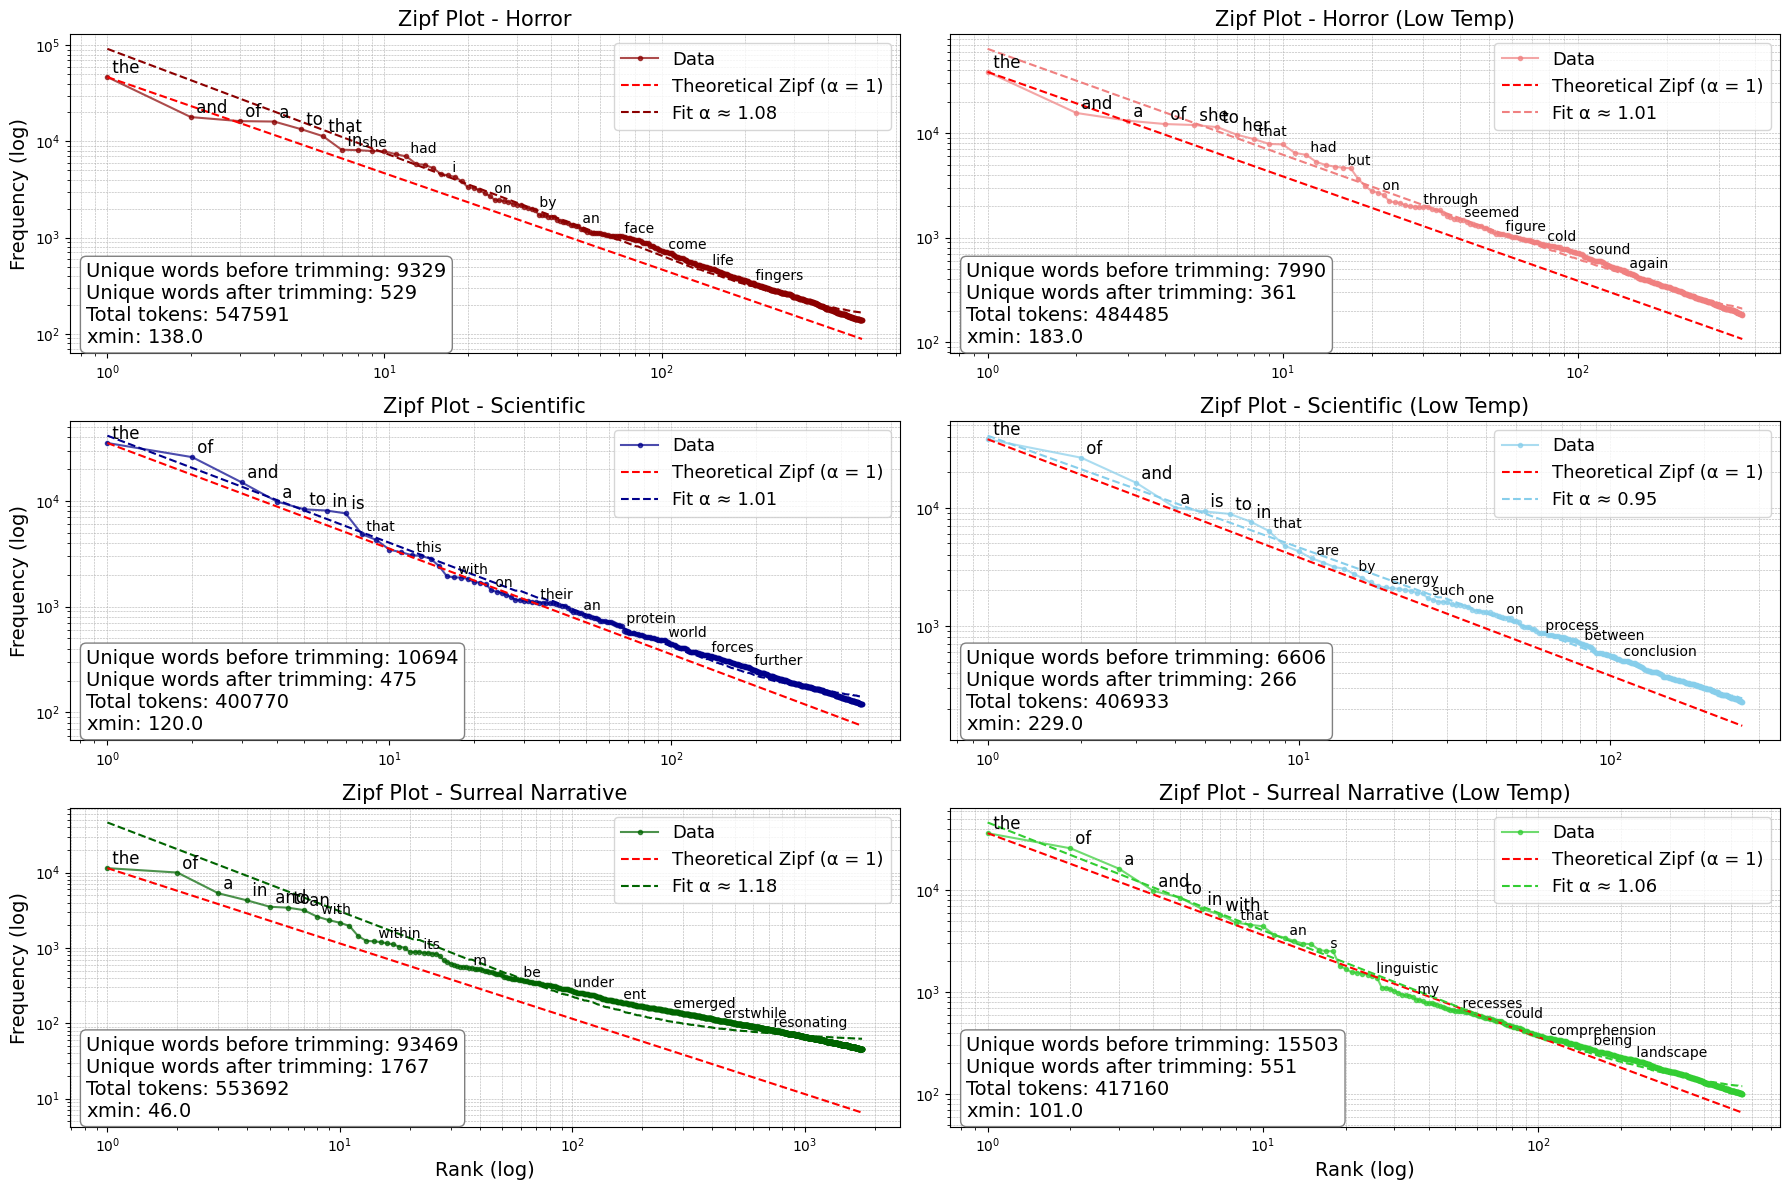

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

plot_zipf(df_horror, axes[0, 0], "Zipf Plot - Horror", color='darkred',
          xmin=xmin_horror, text_length_before=len_horror_before, text_length_after=len_horror_after,
          total_tokens=tokens_horror, show_ylabel=True, show_xlabel=False)

plot_zipf(df_horror_lowtemp, axes[0, 1], "Zipf Plot - Horror (Low Temp)", color='lightcoral',
          xmin=xmin_horror_low, text_length_before=len_horror_low_before, text_length_after=len_horror_low_after,
          total_tokens=tokens_horror_low, show_ylabel=False, show_xlabel=False)

plot_zipf(df_scientific, axes[1, 0], "Zipf Plot - Scientific", color='darkblue',
          xmin=xmin_scientific, text_length_before=len_scientific_before, text_length_after=len_scientific_after,
          total_tokens=tokens_scientific, show_ylabel=True, show_xlabel=False)

plot_zipf(df_scientific_lowtemp, axes[1, 1], "Zipf Plot - Scientific (Low Temp)", color='skyblue',
          xmin=xmin_scientific_low, text_length_before=len_scientific_low_before, text_length_after=len_scientific_low_after,
          total_tokens=tokens_scientific_low, show_ylabel=False, show_xlabel=False)

plot_zipf(df_surreal_narrative, axes[2, 0], "Zipf Plot - Surreal Narrative", color='darkgreen',
          xmin=xmin_surreal, text_length_before=len_surreal_before, text_length_after=len_surreal_after,
          total_tokens=tokens_surreal, show_ylabel=True, show_xlabel=True)

plot_zipf(df_surreal_narrative_lowtemp, axes[2, 1], "Zipf Plot - Surreal Narrative (Low Temp)", color='limegreen',
          xmin=xmin_surreal_low, text_length_before=len_surreal_low_before, text_length_after=len_surreal_low_after,
          total_tokens=tokens_surreal_low, show_ylabel=False, show_xlabel=True)

plt.tight_layout()
plt.show()

To assess the stability of our Zipf exponent estimates, we apply bootstrap resampling. For each corpus, we repeatedly resample the dataset with replacement and compute Zipf’s α on each sample. This allows us to:

- Estimate the mean α across resamples

- Construct 95% confidence intervals for α

This step provides a more robust, distribution-free estimate of uncertainty around each fitted Zipf exponent.

In [11]:
def bootstrap_alpha(df, n=1000):
    alphas = []
    for _ in range(n):
        sample = resample(df)
        log_r = np.log(sample['rank'])
        log_f = np.log(sample['frequency'])
        slope, _, _, _, _ = linregress(log_r, log_f)
        alphas.append(-slope)
    
    ci = np.percentile(alphas, [2.5, 97.5])
    alpha_mean = np.mean(alphas)
    return ci, alpha_mean, alphas  # Return full list too

Bootstrap α estimates with 95% confidence intervals for all corpora

In [12]:
ci_horror, alpha_horror_mean, alpha_samples_horror = bootstrap_alpha(df_horror)
ci_horror_low, alpha_horror_low_mean, alpha_samples_horror_lowtemp = bootstrap_alpha(df_horror_lowtemp)

ci_scientific, alpha_scientific_mean, alpha_samples_scientific = bootstrap_alpha(df_scientific)
ci_scientific_low, alpha_scientific_low_mean, alpha_samples_scientific_lowtemp = bootstrap_alpha(df_scientific_lowtemp)

ci_surreal, alpha_surreal_mean, alpha_samples_surreal = bootstrap_alpha(df_surreal_narrative)
ci_surreal_low, alpha_surreal_low_mean, alpha_samples_surreal_lowtemp= bootstrap_alpha(df_surreal_narrative_lowtemp)

print("Horror α (mean):", alpha_horror_mean)
print("Horror α 95% CI:", ci_horror)

print("\nHorror Low Temp α (mean):", alpha_horror_low_mean)
print("Horror Low Temp α 95% CI:", ci_horror_low)

print("\nScientific α (mean):", alpha_scientific_mean)
print("Scientific α 95% CI:", ci_scientific)

print("\nScientific Low Temp α (mean):", alpha_scientific_low_mean)
print("Scientific Low Temp α 95% CI:", ci_scientific_low)

print("\nSurreal Narrative α (mean):", alpha_surreal_mean)
print("Surreal Narrative α 95% CI:", ci_surreal)

print("\nSurreal Narrative Low Temp α (mean):", alpha_surreal_low_mean)
print("Surreal Narrative Low Temp α 95% CI:", ci_surreal_low)

Horror α (mean): 1.084300918291965
Horror α 95% CI: [1.05489231 1.11497348]

Horror Low Temp α (mean): 1.0145758229137871
Horror Low Temp α 95% CI: [0.98373555 1.04396369]

Scientific α (mean): 1.0134770450850927
Scientific α 95% CI: [1.00047924 1.02783248]

Scientific Low Temp α (mean): 0.9452609001025156
Scientific Low Temp α 95% CI: [0.93062677 0.95951973]

Surreal Narrative α (mean): 1.1832653508208724
Surreal Narrative α 95% CI: [1.13930219 1.23267187]

Surreal Narrative Low Temp α (mean): 1.0581086720693844
Surreal Narrative Low Temp α 95% CI: [1.046159   1.07028383]


We evaluate whether temperature affects the Zipf exponent α consistently across topics. For each topic (Horror, Scientific, Surreal Narrative), we perform a two-sample Welch’s t-test on the bootstrap distributions of α between the high- and low-temperature versions.

More on Welch's t-test: it is a version of the t-test which does not assume equal variances between groups and is robust when sample sizes or variances differ.

-- H0: the mean of alpha high-temp and alpha low-temp is the same 

-- H1:        //                differ


This allows us to:

- Statistically test whether temperature has a significant effect on lexical scaling behavior

- Visualize the distributional shift in α using kernel density plots

All comparisons are made between the same topic at different temperatures.

T-test between Horror and Horror Low Temp:
t-statistic: 102.77916518230225
p-value: 0.0


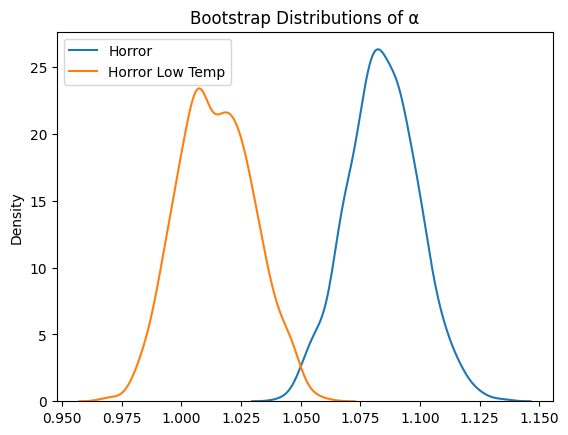

In [13]:
t_stat, p_value = ttest_ind(alpha_samples_horror, alpha_samples_horror_lowtemp, equal_var=False)

print("T-test between Horror and Horror Low Temp:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

sns.kdeplot(alpha_samples_horror, label='Horror')
sns.kdeplot(alpha_samples_horror_lowtemp, label='Horror Low Temp')
plt.title("Bootstrap Distributions of α")
plt.legend()
plt.show()

T-test between Horror and Horror Low Temp:
t-statistic: 219.87238783437274
p-value: 0.0


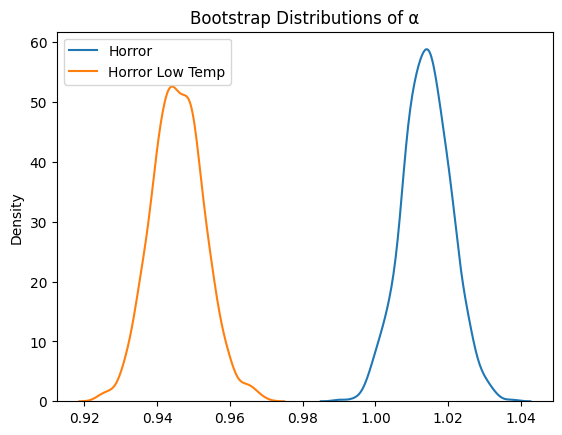

In [14]:
t_stat, p_value = ttest_ind(alpha_samples_scientific, alpha_samples_scientific_lowtemp, equal_var=False)

print("T-test between Horror and Horror Low Temp:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

sns.kdeplot(alpha_samples_scientific, label='Horror')
sns.kdeplot(alpha_samples_scientific_lowtemp, label='Horror Low Temp')
plt.title("Bootstrap Distributions of α")
plt.legend()
plt.show()

T-test between Horror and Horror Low Temp:
t-statistic: 150.74457297442848
p-value: 0.0


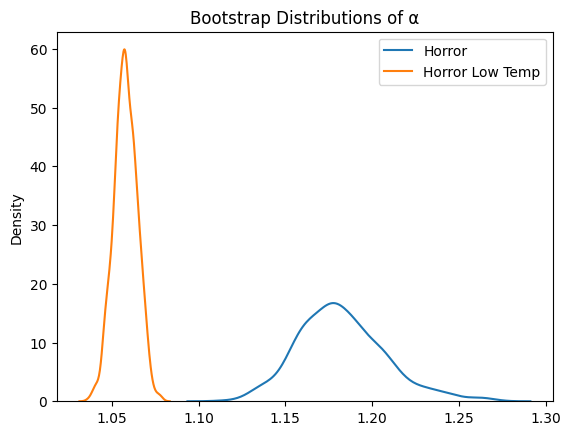

In [15]:
t_stat, p_value = ttest_ind(alpha_samples_surreal, alpha_samples_surreal_lowtemp, equal_var=False)

print("T-test between Horror and Horror Low Temp:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

sns.kdeplot(alpha_samples_surreal, label='Horror')
sns.kdeplot(alpha_samples_surreal_lowtemp, label='Horror Low Temp')
plt.title("Bootstrap Distributions of α")
plt.legend()
plt.show()

Compute the average Zipf exponents (α) from the bootstrap samples for each corpus-temperature combination. These means will be used for correlation analysis and summary reporting.

In [13]:
alpha_horror_low_mean = np.mean(alpha_samples_horror_lowtemp)
alpha_scientific_mean = np.mean(alpha_samples_scientific)
alpha_scientific_low_mean = np.mean(alpha_samples_scientific_lowtemp)
alpha_surreal_mean = np.mean(alpha_samples_surreal)
alpha_surreal_low_mean = np.mean(alpha_samples_surreal_lowtemp)

Create a summary table containing the mean Zipf exponent, minimum rank cutoff (xmin), and vocabulary size (before and after trimming) for each corpus variant

In [ ]:
df_corpus = pd.DataFrame({
    'Corpus': [
        'Horror', 'Horror Low Temp',
        'Scientific', 'Scientific Low Temp',
        'Surreal', 'Surreal Low Temp'
    ],
    'Alpha': [
    alpha_horror_mean, alpha_horror_low_mean,
    alpha_scientific_mean, alpha_scientific_low_mean,
    alpha_surreal_mean, alpha_surreal_low_mean
],
    'Xmin': [
        xmin_horror, xmin_horror_low,
        xmin_scientific, xmin_scientific_low,
        xmin_surreal, xmin_surreal_low
    ],
    'Unique words before': [
        len_horror_before, len_horror_low_before,
        len_scientific_before, len_scientific_low_before,
        len_surreal_before, len_surreal_low_before
    ],
    'Unique words after': [
        len_horror_after, len_horror_low_after,
        len_scientific_after, len_scientific_low_after,
        len_surreal_after, len_surreal_low_after
    ]
})

We examine how the Zipf exponent 
𝛼
relates to key text features:

- xmin (cutoff rank for Zipf fitting)

- Unique words before trimming

- Unique words after trimming

Pearson’s 
𝑟
 and p-values indicate whether lexical scaling is influenced by vocabulary size or fitting range.

In [16]:
# Alpha vs Xmin
r_xmin, p_xmin = pearsonr(df_corpus['Alpha'], df_corpus['Xmin'])
print(f"Correlation between Alpha and Xmin: r = {r_xmin:.3f}, p = {p_xmin:.4f}")

# Alpha vs Text Length
r_len, p_len = pearsonr(df_corpus['Alpha'], df_corpus['Unique words before'])
print(f"Correlation between Alpha and 'Unique words before': r = {r_len:.3f}, p = {p_len:.4f}")

# Alpha vs Xmin
r_xmin, p_xmin = pearsonr(df_corpus['Alpha'], df_corpus['Unique words after'])
print(f"Correlation between Alpha and 'Unique words after': r = {r_xmin:.3f}, p = {p_xmin:.4f}")

Correlation between Alpha and Xmin: r = -0.893, p = 0.0167
Correlation between Alpha and 'Unique words before': r = 0.838, p = 0.0374
Correlation between Alpha and 'Unique words after': r = 0.898, p = 0.0149
